In [1]:
# %pip install -U lsdb

In [2]:
from pathlib import Path

import lsdb
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client
from hats.inspection import plot_density
from hats.inspection.visualize_catalog import plot_healpix_map
from matplotlib.colors import LogNorm

In [16]:
def healpix_pixel_area_sqdeg(order: int) -> float:
    return 4 * np.pi * (180 / np.pi)**2 / (12 * 4**order)

In [4]:
catalog_path = Path('/data3/epyc/data3/hats/catalogs/ztf_dr22/ztf_lc')
order = 7

Dask NestedFrame Structure:
                          filterid                                                          lc
npartitions=10839                                                                             
0                    int8[pyarrow]  nested<hmjd: [double], catflags: [int32], magerr: [float]>
1125899906842624               ...                                                         ...
...                            ...                                                         ...
3458483038843830272            ...                                                         ...
3458764513820540928            ...                                                         ...
Dask Name: lambda, 4 expressions
Expr=MapPartitions(lambda)

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - ztf_lc'}>)

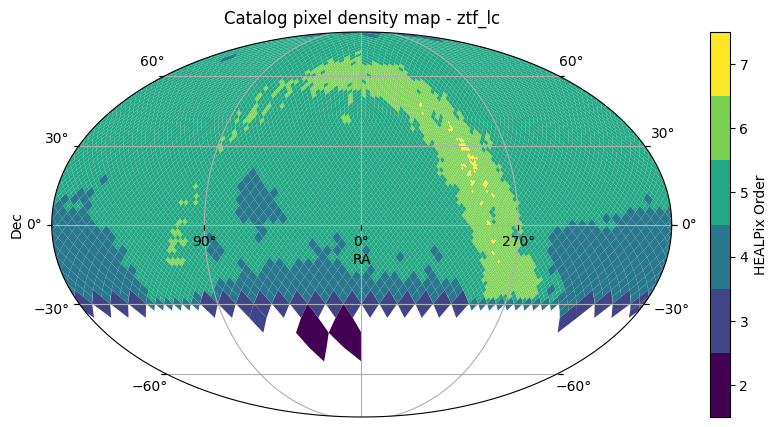

In [5]:
cat = lsdb.read_hats(
    catalog_path,
    columns=["filterid", "hmjd", "catflags", "magerr"],
).nest_lists(
    base_columns=["filterid"],
    name="lc",
)
display(cat)
cat.plot_pixels()

(<Figure size 2400x1200 with 2 Axes>,
 <WCSAxes: title={'center': 'Angular density of catalog ztf_lc'}>)

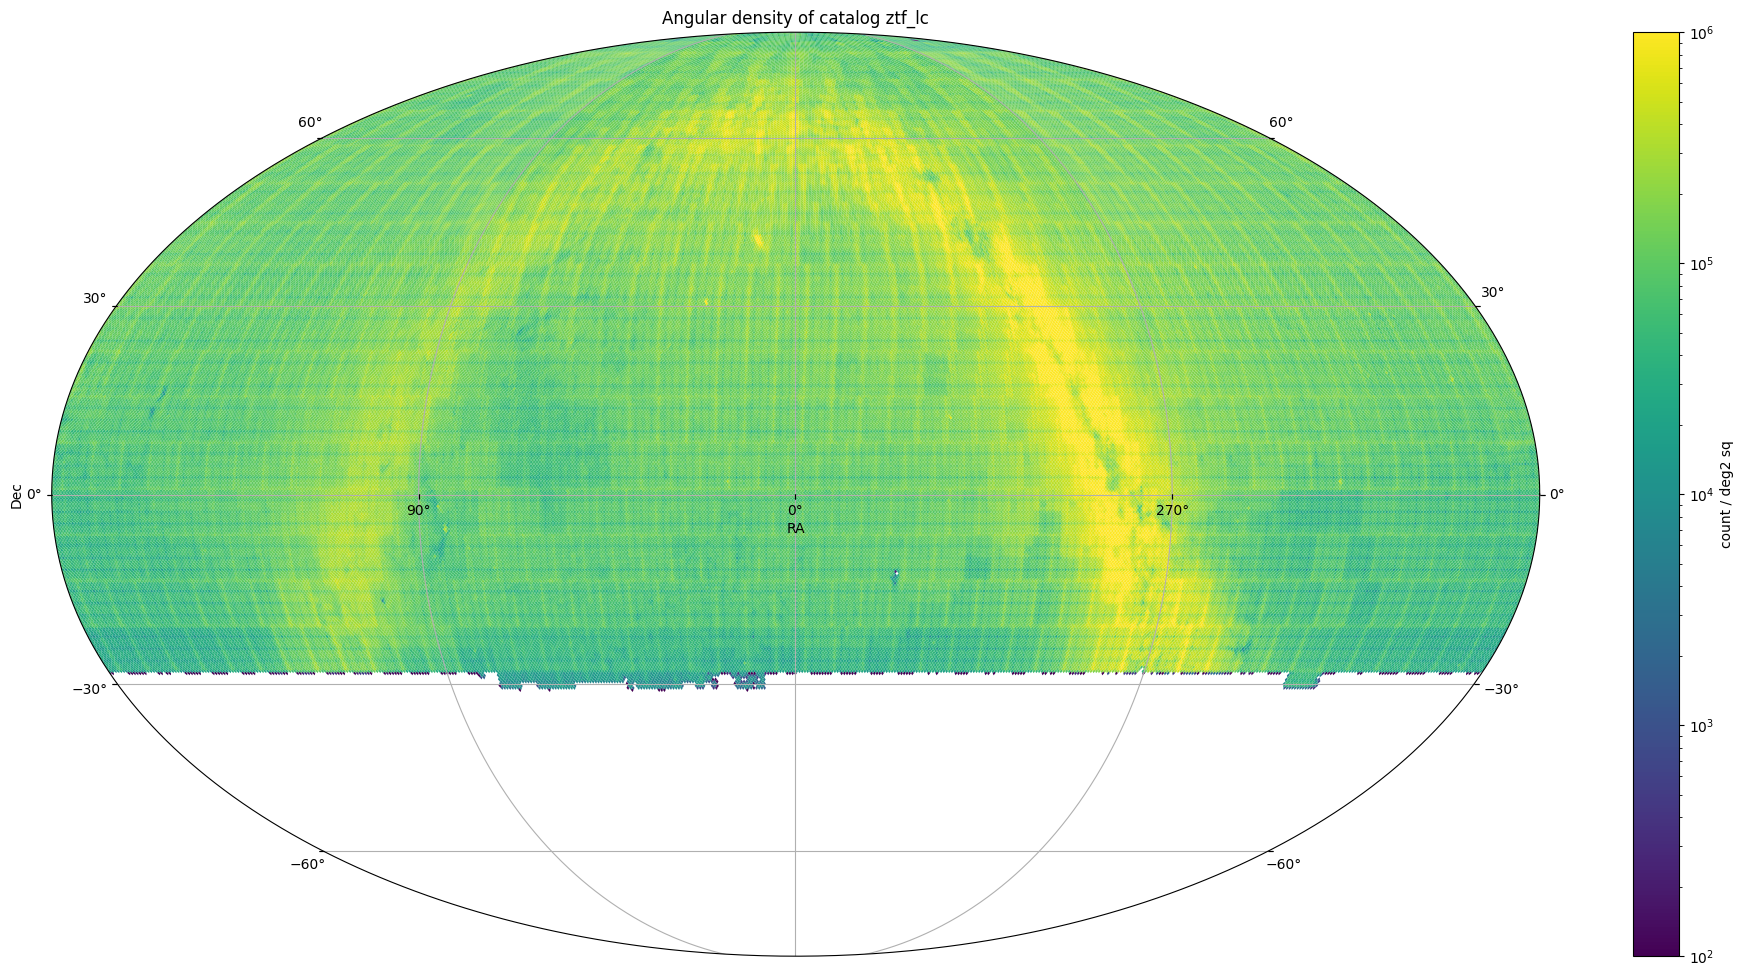

In [14]:
plt.figure(figsize=(24, 12))
plot_density(cat.hc_structure, order=order, edgecolors='None', norm=LogNorm(vmin=100, vmax=1e6))

In [7]:
filtered_cat = cat.query(
    "filterid == 2"
).query(
    "lc.catflags == 0"
    " and lc.magerr > 0.0"
    " and lc.hmjd >= 58178 and lc.hmjd <= 60125"
).map_partitions(
    lambda nf: nf.assign(
        nobs=nf["lc"].nest.list_lengths,
    ).drop(
        columns=nf.columns,
    ),
).query(
    "nobs >= 100",
)

In [8]:
with Client(
        n_workers=12,
        memory_limit="36GB",
        threads_per_worker=1,
        env=dict(ARROW_DEFAULT_MEMORY_POOL="jemalloc"),
        dashboard_address=":48787",
) as client:
    display(client)
    skymap = filtered_cat.skymap_histogram(
        lambda df, _pix: len(df) / healpix_pixel_area_sqdeg(order),
        order=order,
    )

<Client: 'tcp://127.0.0.1:45875' processes=12 threads=12, memory=402.33 GiB>

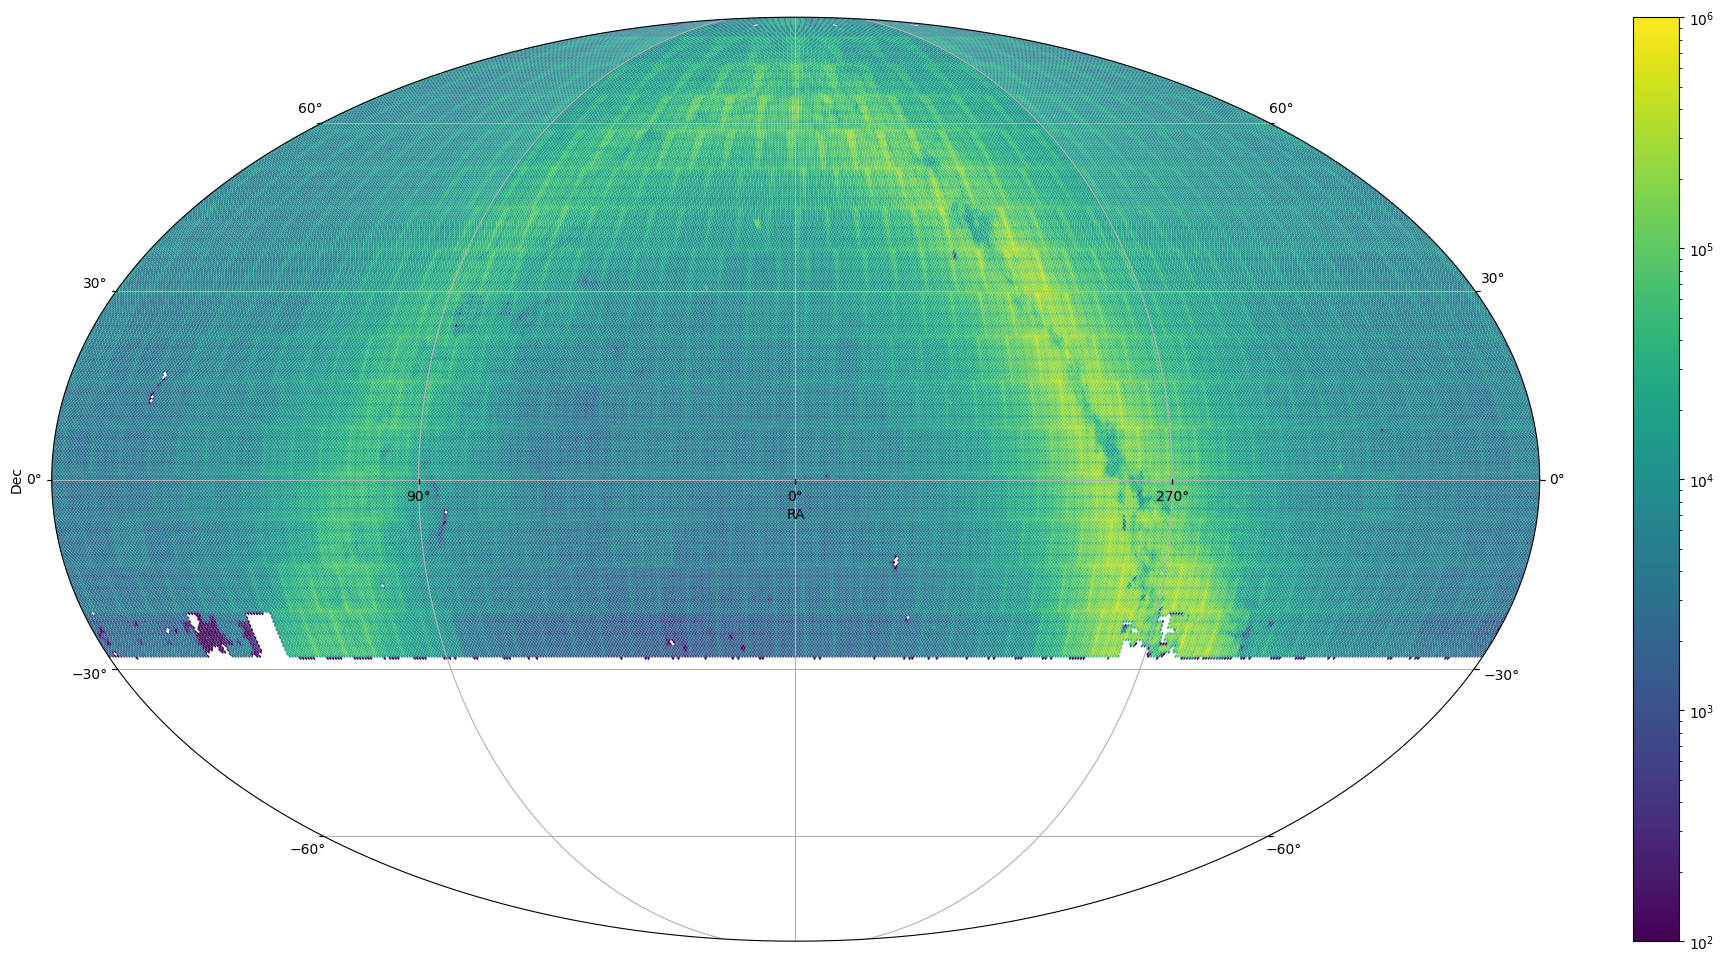

In [17]:
plt.figure(figsize=(24, 12))
plot_healpix_map(skymap, norm=LogNorm(vmin=100, vmax=1e6))
plt.savefig('skymap.pdf')